# Modelling the UK's Long-term Gas Demand
This notebook contains the code developed as part of my personal project to develop a forecasting model for the UK's natural gas demand using Prophet.

Historical data will be taken from a quarterly basis, and will be used to forecast for the long-term, meaning 12-quarters or 3 years in advance. Unfortunately, no data was available on a monthly basis, and if I took annual data, the number of datapoints would likely be insufficient for a proper analysis.  

This notebook is broken down into 4 sections:
1. Data Processing
2. Data Analysis
3. Modelling
4. Results and Next Steps

## 0. Install Packages

In [716]:
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from prophet.diagnostics import performance_metrics, cross_validation

## 1. Data Processing
For simplicity of this project, I have compiled and pre-uploaded all data that is needed for this analysis into a csv file. All data was sourced from GOV.UK.

The data obtained includes:
- UK gas consumption data split by sector/use case
- UK weather data
- UK domestic and industrial gas prices

### Read and Inspect data

In [717]:
# Read CSV file
df = pd.read_csv('gas_data.csv')

# Inspect data
display(df.shape)
display(df.dtypes)
display(df.isnull().any())
display(df.head(1))

(96, 12)

date                    object
electricity            float64
domestic               float64
industrial             float64
total_demand           float64
rainfall               float64
sunhours               float64
windspeed              float64
temperature            float64
heating_degree_days    float64
domestic_price         float64
industrial_price       float64
dtype: object

date                   False
electricity            False
domestic               False
industrial             False
total_demand           False
rainfall               False
sunhours               False
windspeed              False
temperature            False
heating_degree_days    False
domestic_price         False
industrial_price       False
dtype: bool

,date,electricity,domestic,industrial,total_demand,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price
0,Q1 2001,117221.0,154586.0,102419.0,374226.0,249.248935,2.832804,8.794621,4.714601,8.535148,50.659417,63.146926


### Convert date to datetime format

In [718]:
df['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df['date']])
df.head(1)

C:\Users\benja\AppData\Local\Temp\ipykernel_12252\404672300.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime([f'{x[-4:]}-{x[:2]}' for x in df['date']])


,date,electricity,domestic,industrial,total_demand,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price
0,2001-01-01,117221.0,154586.0,102419.0,374226.0,249.248935,2.832804,8.794621,4.714601,8.535148,50.659417,63.146926


## 2. Data Analysis

### UK Total Gas Consumption (From 2001) 


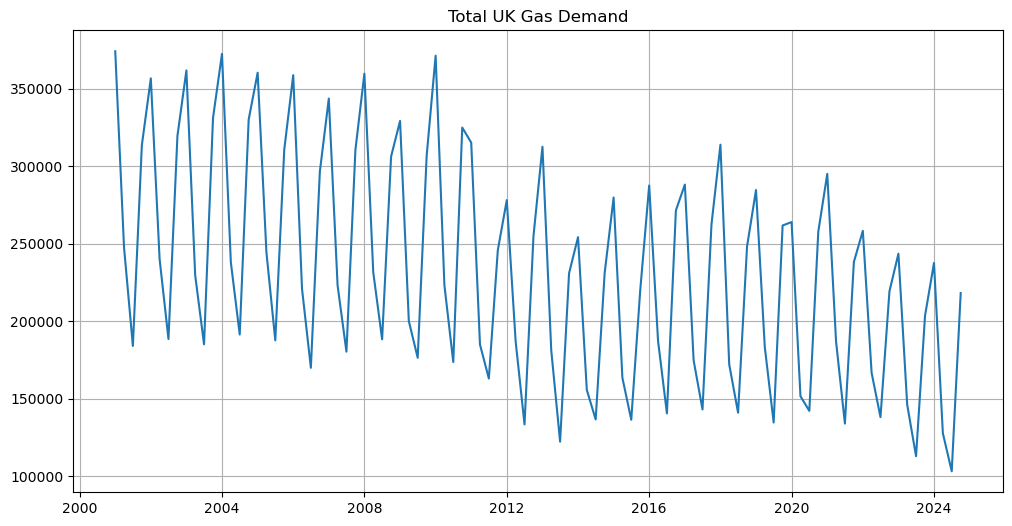

In [719]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['date'], df['total_demand'])
ax.set_title('Total UK Gas Demand')
ax.grid(True)

Let's use statsmodels decomposition tool to explore further

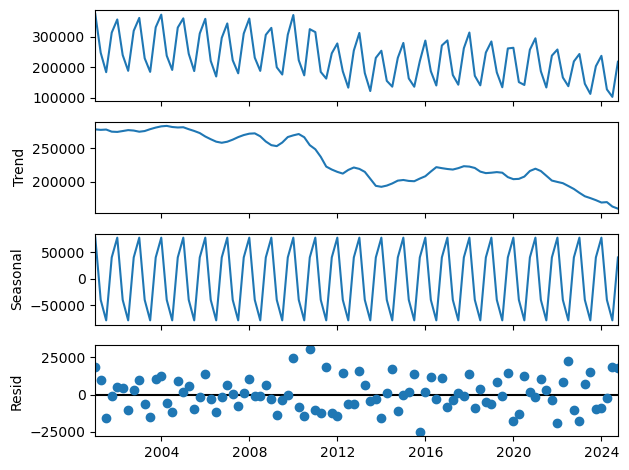

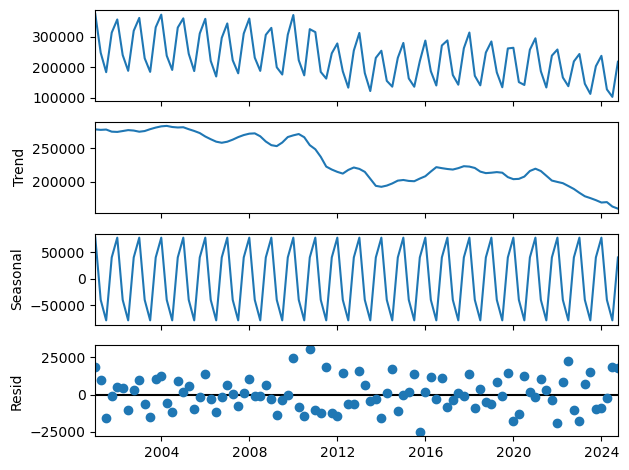

In [720]:
df_breakdown = df[['date','total_demand']]
df_breakdown.set_index('date', inplace=True)

seasonal_breakdown = seasonal_decompose(df_breakdown, model='additive', extrapolate_trend='freq')
seasonal_breakdown.plot()


Overall, the data displays a downward trend with annual seasonal cycles, reflecting gas demand cyclicality due to annual weather variations. Let's break down the total demand by sector to learn more. 

### UK Gas Consumption by Sector
The UK's gas consumption data is split in very fine detail. A very quick look at the data shows that domestic consumption and electricity generation consumption by far outweights the other columns.

To simplify, I will combine all consumption columns into a non-domestic sector. This leaves us with 3 main sectors: 
- Domestic: Gas consumed purely by households
- Non-Domestic: Gas consumed under the industrial sector as well as other non-domestic sectors(commercial,services,transport)
- Electricity: Final gas demand which includes gas consumed for primary electricity generation/transformation and distribution losses

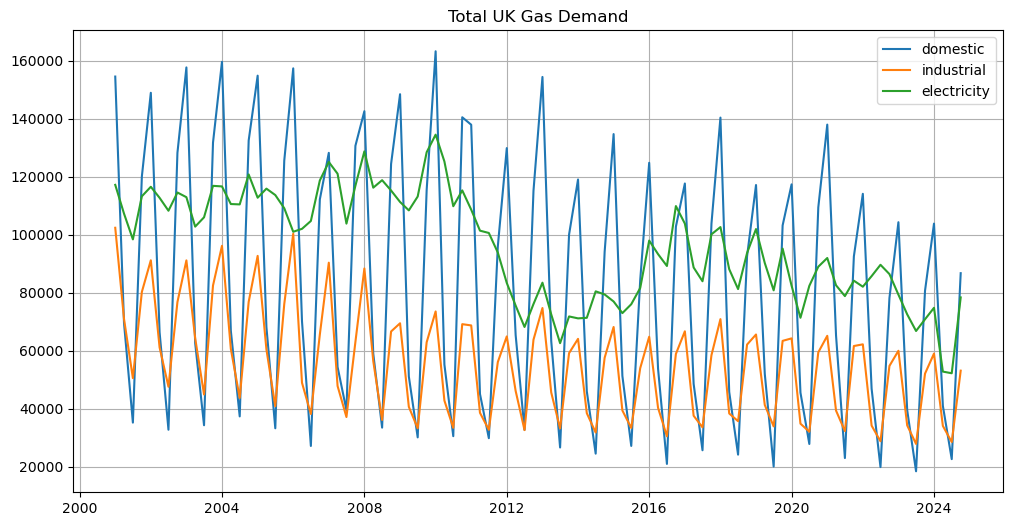

In [721]:
fig, ax = plt.subplots(figsize=(12,6))
for i in ['domestic','industrial','electricity']:
    ax.plot(df['date'], df[i], label=i)
ax.legend()
ax.set_title('Total UK Gas Demand')
ax.grid(True)


Overall, seasonal cycles are more evident within the domestic and non-domestic sectors, and the mean does not vary significantly. The peaks and troughs of demand are more prominent for the domestic sector.

The demand for gas in electricity generation displays less seasonality, and is more volatile comparably. There is a period starting from approximately 2010 where gas demand for electricity generation drops significantly. This is likely due to the increase in coal-powered stations which reduces the demand of gas needed for electricity generation.

The demand for gas under each sector is influenced by different factors, and as such the demand will be modelled separately. 

### Analysis on External Variables
I've also compiled data on external variables that are likely to influence gas demand, e.g. gas prices and the weather.

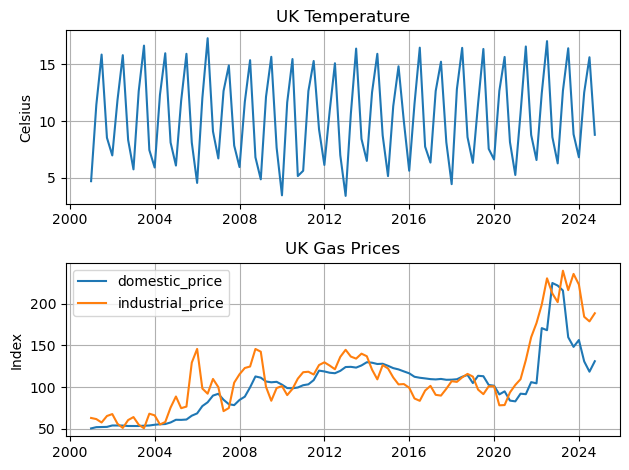

In [722]:
fig, ax = plt.subplots(2,1)
ax[0].plot(df['date'], df['temperature'])
for i in ['domestic_price','industrial_price']:
    ax[1].plot(df['date'], df[i], label=i)
ax[0].set_title('UK Temperature')
ax[1].set_title('UK Gas Prices')
ax[0].set_ylabel('Celsius')
ax[1].set_ylabel('Index')
ax[0].grid(True)
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()

Temperature data displays significant annual cyclicality.
Domestic gas prices and industrial gas prices generally follow the same trend, though industrial prices are more volatile. Gas prices saw a significant spike in 2022 as a result of the Russia-Ukraine war leading to the energy crisis.

## 3. Modelling
### Setting up the Dataframe for Modelling
The last 8 quarters (last 2 years) will be used as the test set. The training/test set will be split 80/20.


In [723]:
# Rename date column to ds
df = df.rename(columns={'date':'ds'})

# Create a function to split df into training set and test set
def split_train_test_set(df, training_start="%Y-%m-%d", test_start="%Y-%m-%d"):
    df_train = df[(df['ds'] >= pd.Timestamp(training_start)) & (df['ds'] < pd.Timestamp(test_start))]
    df_test = df[df['ds'] >= pd.Timestamp(test_start)]
    return df_train, df_test


def scale_regressor(df, columns):
    df[[f'{i}_scaled' for i in columns]] = StandardScaler().fit_transform(df[columns])


# Create a function to forecast accuracy of predicted set vs test set
def forecast_accuracy(test_set, forecast_set):
    y_true = test_set['y'].values
    y_forecast = forecast_set['yhat'][-len(test_set):].values

    rmse = np.sqrt(mean_squared_error(y_true, y_forecast))
    mape = mean_absolute_percentage_error(y_true, y_forecast)

    print('RMSE: %.2f' %rmse)
    print('MAPE: %.2f' % mape)

### Modelling Domestic Gas Demand
In a domestic context, gas demand is used primarily for space heating. This means that gas demand are likely to be primarily influenced by external factors like temperature. The colder it is, the more gas that is demanded to heat up domestic homes. Hence, the UK's quarterly temperature data is used as an external regressor.

Additionally, domestic gas prices are also likely to play an influence on gas demand.  

In [724]:
df = df.rename(columns={'domestic':'y'})

#Scale all external regressors
scale_regressor(df, ['temperature','heating_degree_days','domestic_price'])

#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    growth='linear',
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,    #default value
    seasonality_prior_scale=10      #default value
    )
model.add_regressor('temperature_scaled', mode='multiplicative')
model.add_regressor('domestic_price_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)


23:09:20 - cmdstanpy - INFO - Chain [1] start processing
23:09:21 - cmdstanpy - INFO - Chain [1] done processing


In [725]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')
df_future.tail(5)

,ds,electricity,y,industrial,total_demand,rainfall,sunhours,windspeed,temperature,heating_degree_days,domestic_price,industrial_price,temperature_scaled,heating_degree_days_scaled,domestic_price_scaled
35,2023-10-01,70853.06,80708.44,52099.51,203661.01,458.254277,2.105616,9.068274,8.847127,6.711361,148.247093,235.610007,-0.399788,0.377330,1.290168
36,2024-01-01,74806.34,103849.08,59018.43,237673.84,405.990154,2.433354,9.382006,6.818524,8.681476,156.467156,222.860382,-0.911014,0.937140,1.522690
37,2024-04-01,52800.03,40982.33,34065.71,127848.07,254.473992,5.612069,7.989517,12.513213,3.176164,130.877542,184.296719,0.524097,-0.627200,0.798833
38,2024-07-01,52226.37,22601.38,28501.29,103329.04,334.713264,5.312244,7.850166,15.614907,0.925958,118.535679,178.765668,1.305750,-1.266599,0.449717
39,2024-10-01,78393.55,86749.50,53126.00,218269.05,391.304525,1.944740,8.565454,8.793698,6.706302,131.077109,188.494133,-0.413253,0.375892,0.804478


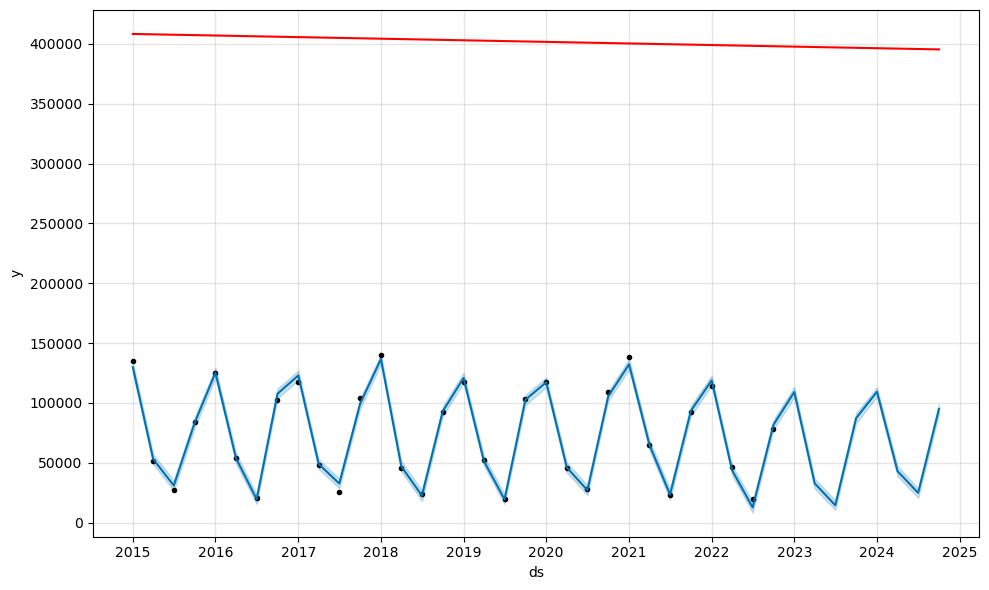

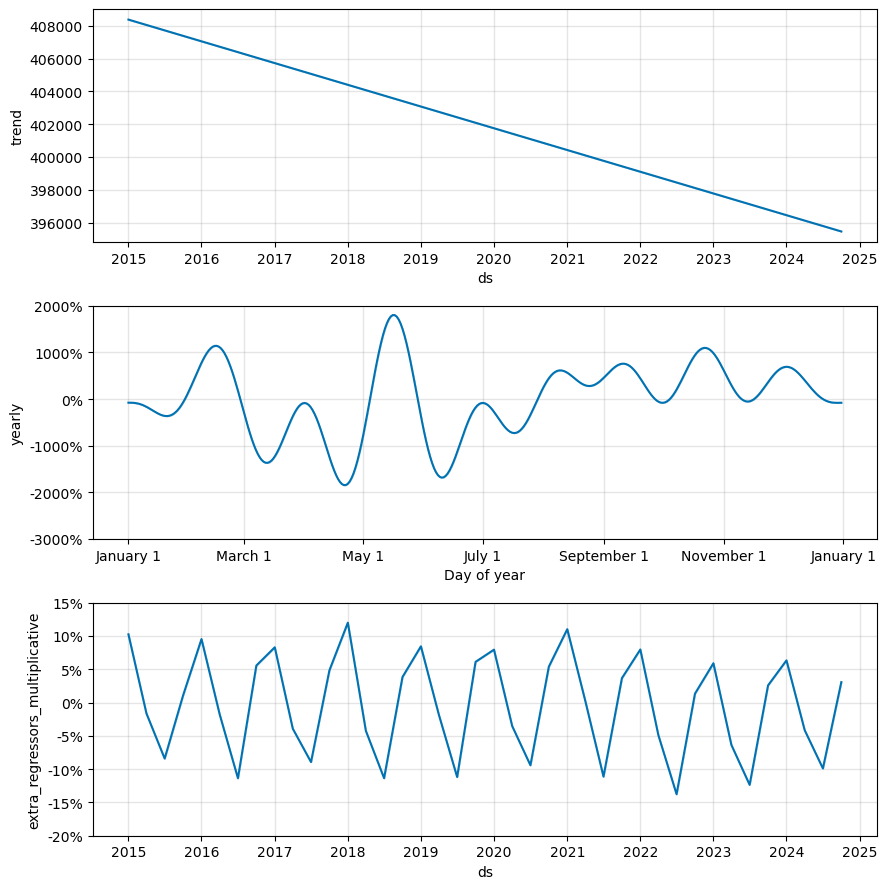

In [726]:
df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [727]:
forecast_accuracy(df_test, df_forecast)

RMSE: 5419.39
MAPE: 0.10


OK, a MAPE of 10% isn't bad for a start, but let's see how we can refine our predictions further.

3 main refinements identified: 
1. Prophet hyperparameter tuning 
    - Adjust sensitivities of trend and seasonality
2. Adjust for energy crisis
    - The energy crisis which caused a spike in gas prices from 2022 may have caused a structural shift in domestic consumption behaviour. Existing gas price levels have yet to return to long-term historical averages.
    - High energy prices likely caused some form of demand destruction, and users may have taken efforts to improve energy efficiencies, meaning that demand is likely to be affected moving forwards.
    - Hence, I will treat the post-energy crisis period as a one-off holiday feature     
    - The effect of gas prices on gas demand is likely different post-energy crisis. Therefore I will add an interaction term (price x energy_crisis)
3. Setup lag features for external regressors
    - Demand may have delayed responses to external variables, I suspect this is the case for domestic prices       

In [728]:
# Set a one step lag for domestic prices and backfill for any NaN values
df['domestic_price_lag'] = df['domestic_price'].shift(1)
df['domestic_price_lag'] = df['domestic_price_lag'].bfill()

# Treat the pre/ post-energy crisis period as a binary indicator
df['crisis'] = (df['ds'] >= '2022-01-01').astype(int)

# Add an interaction term for domestic prices and the energy crisis
df['domestic_price_interaction'] = df['domestic_price_lag'] * df['crisis']

# Scale new regressors
scale_regressor(df, ['domestic_price_lag','crisis','domestic_price_interaction'])

#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=10  
    )
model.add_regressor('temperature_scaled', mode='multiplicative')
model.add_regressor('domestic_price_lag_scaled', mode='multiplicative')
model.add_regressor('crisis_scaled', mode='multiplicative')
model.add_regressor('domestic_price_interaction_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)


23:09:23 - cmdstanpy - INFO - Chain [1] start processing
23:09:23 - cmdstanpy - INFO - Chain [1] done processing


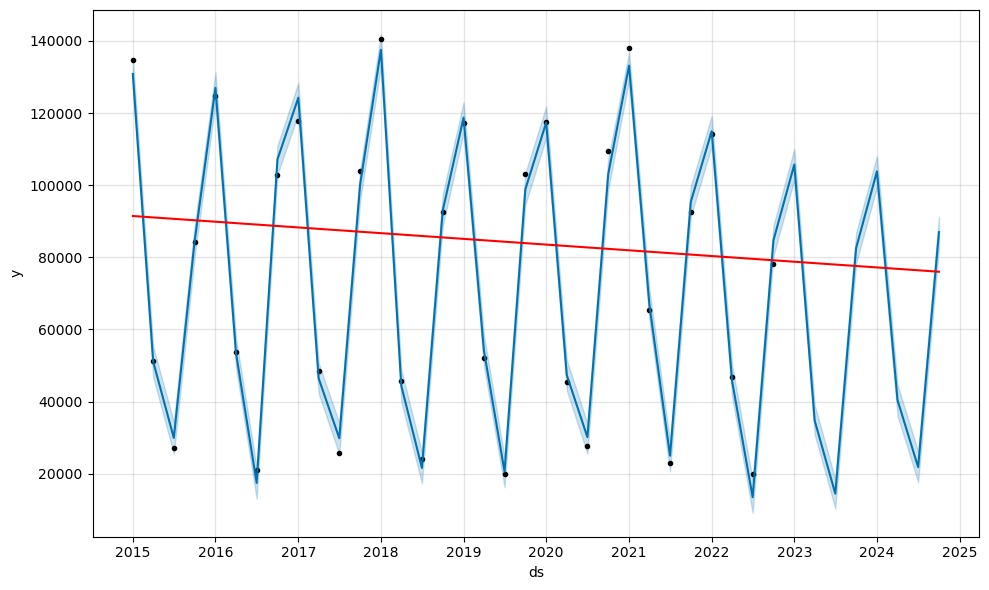

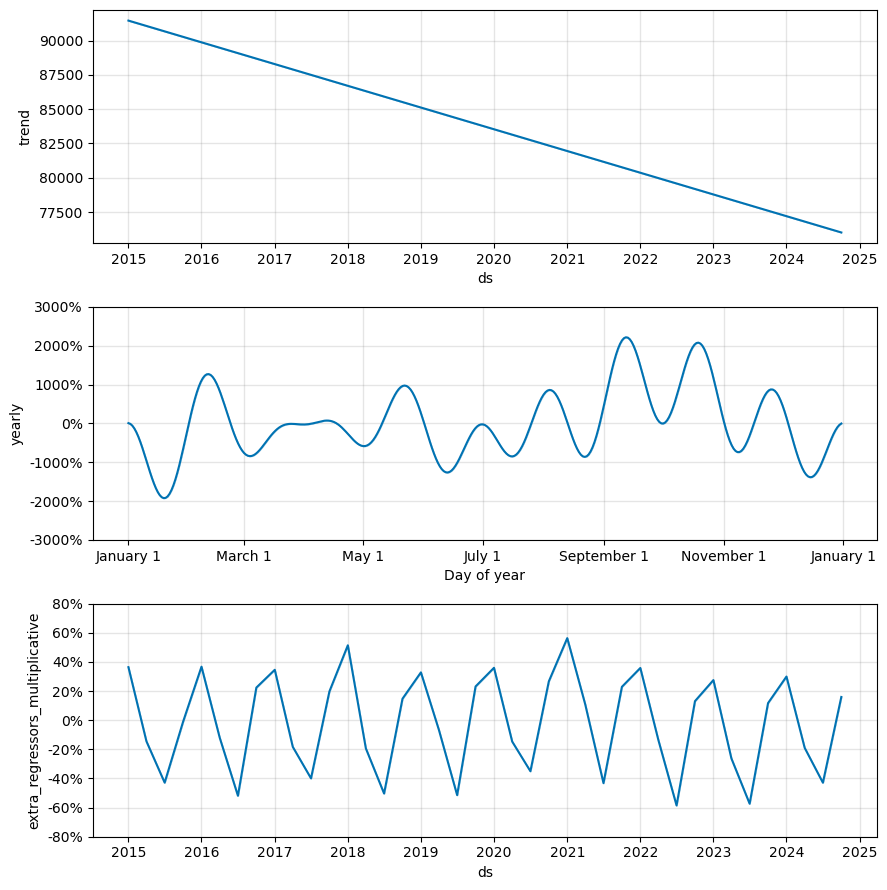

In [729]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')

df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [730]:
forecast_accuracy(df_test, df_forecast)

RMSE: 2359.89
MAPE: 0.05


Results improved. 

### Modelling Non-domestic Gas Demand
Same methodology as above, now using industrial gas prices as a predictor variable instead.

In [731]:
df = df.rename(columns={'industrial':'y', 'y':'domestic'})

# Set a one step lag for industrial prices and backfill for any NaN values
df['industrial_price_lag'] = df['industrial_price'].shift(1)
df['industrial_price_lag'] = df['industrial_price_lag'].bfill()

# Add an interaction term for industrial prices and the energy crisis
df['industrial_price_interaction'] = df['industrial_price_lag'] * df['crisis']

# Scale new regressors
scale_regressor(df, ['industrial_price_lag','industrial_price_interaction'])

#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    growth='linear',
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,  
    seasonality_prior_scale=10
    )
model.add_regressor('temperature_scaled', mode='multiplicative')
model.add_regressor('industrial_price_lag_scaled', mode='multiplicative')
model.add_regressor('crisis_scaled', mode='multiplicative')
model.add_regressor('industrial_price_interaction_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)


23:09:25 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing


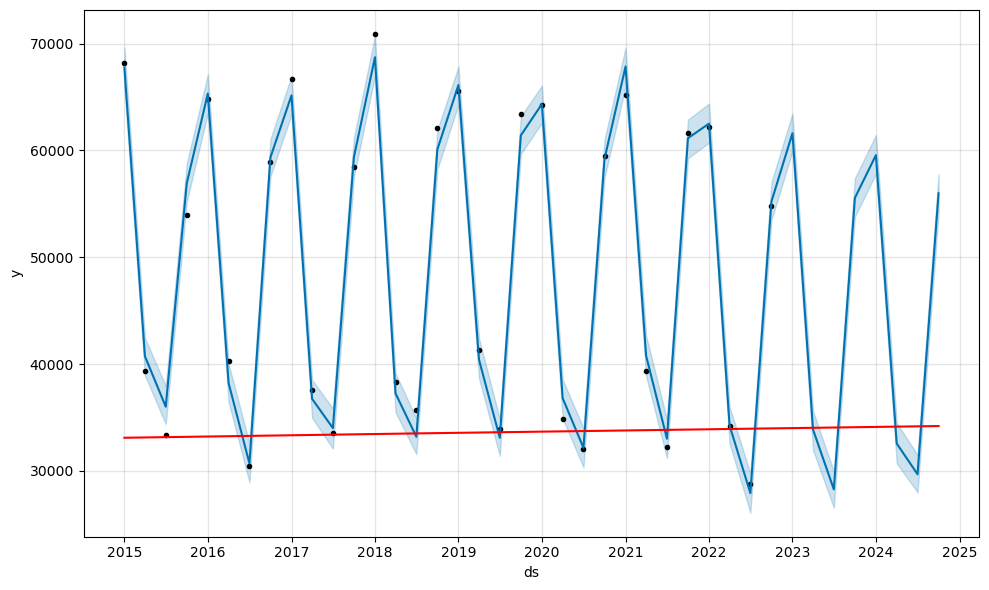

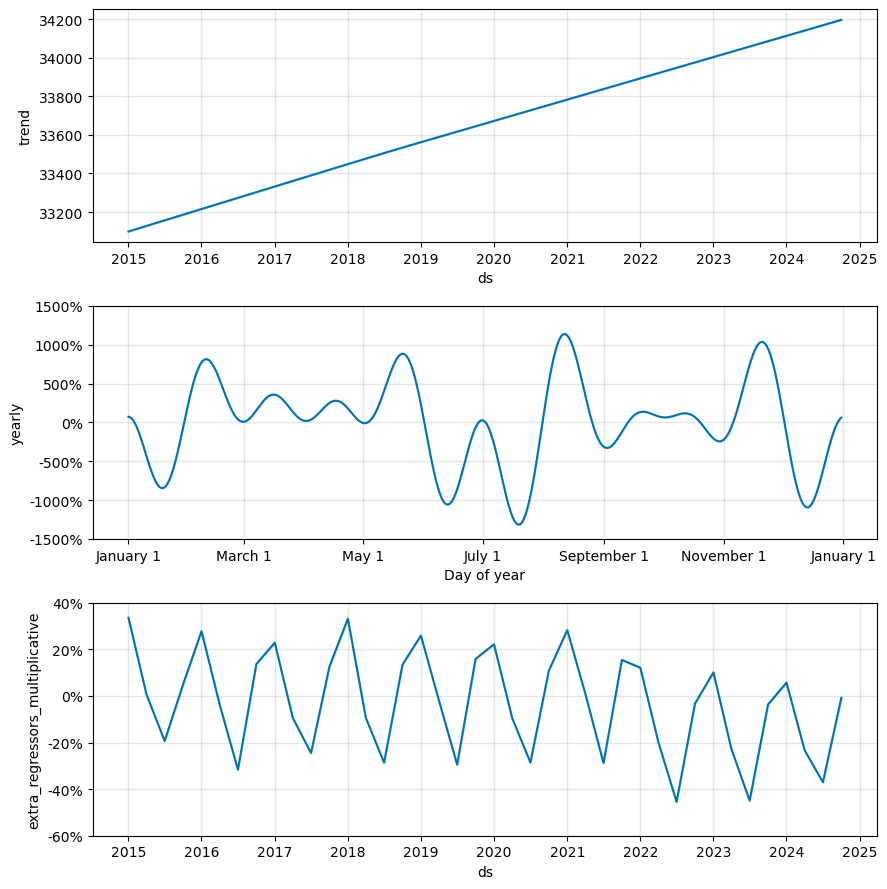

In [732]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')

df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [733]:
forecast_accuracy(df_test, df_forecast)

RMSE: 1835.35
MAPE: 0.03


A MAPE of 3% is a significant improvement

### Modelling Electricity Demand
Gas demand for use in electricity generation is typically dependent on availability from renewable energy sources that suffer from intermittency, like solar and wind. For example, gas is used as backup demand if electricity generation from renewables is low. 

I will use windspeeds and sunhours as regressors as they determine electricity generated from wind and solar plants, which subsequently affects backup gas demand required.

In [734]:
df = df.rename(columns={'electricity':'y', 'y':'industrial'})


# Scale new regressors
scale_regressor(df, ['sunhours','windspeed'])

#Split training set/ test set
df_train, df_test = split_train_test_set(df, '2015-01-01', '2023-01-01')

#Setup model
model = Prophet(
    growth='linear',
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,  
    seasonality_prior_scale=10
    )
model.add_regressor('sunhours_scaled', mode='multiplicative')
model.add_regressor('windspeed_scaled', mode='multiplicative')

#Fit model to training data
model.fit(df_train)

23:09:27 - cmdstanpy - INFO - Chain [1] start processing
23:09:28 - cmdstanpy - INFO - Chain [1] done processing


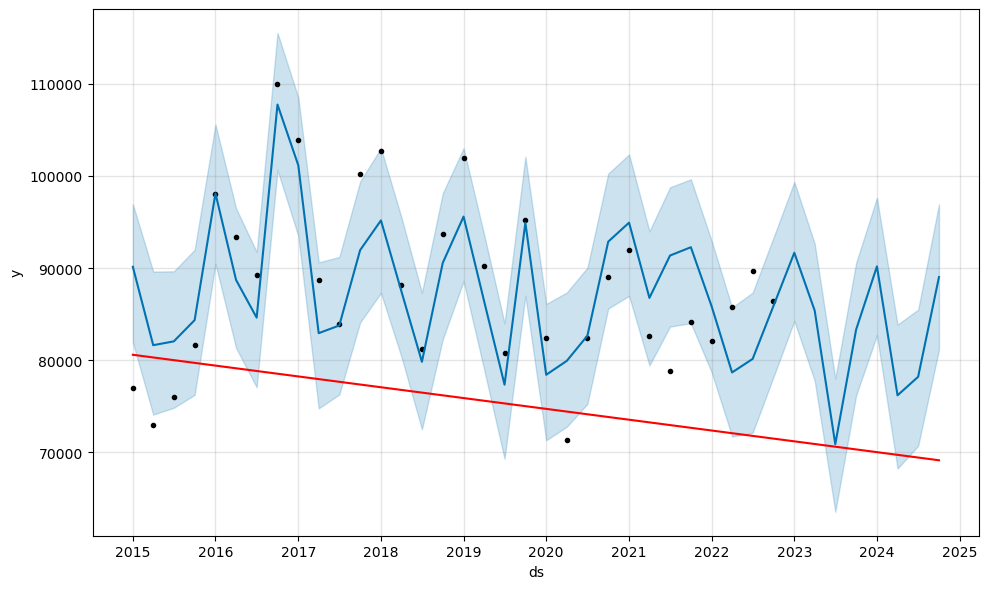

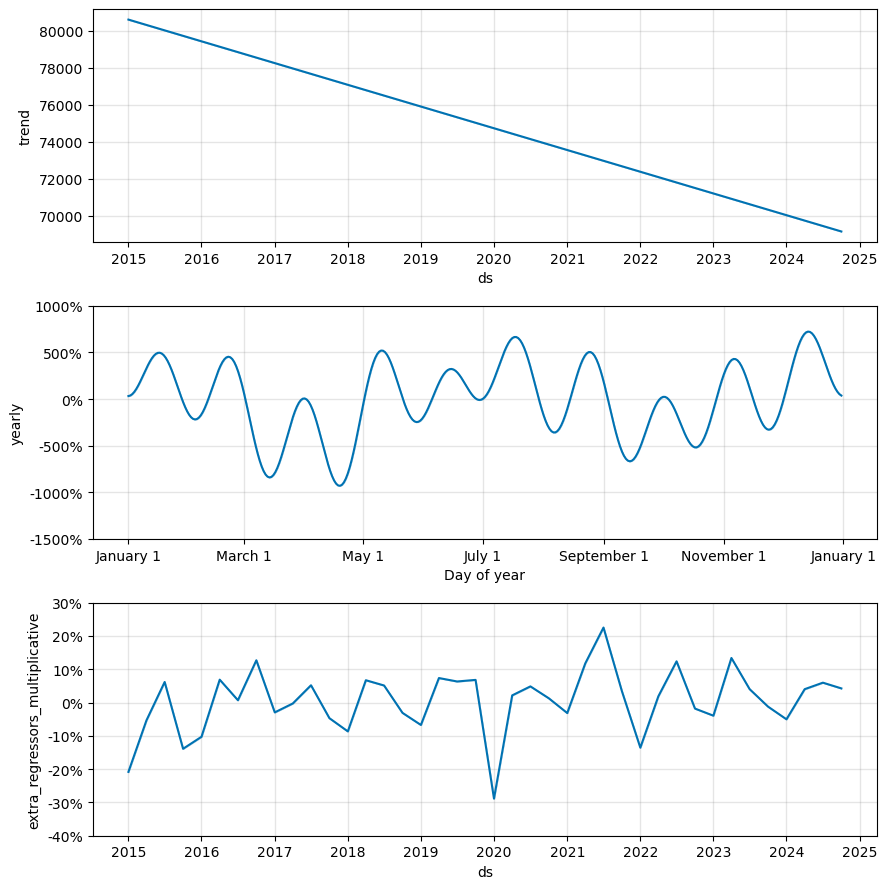

In [735]:
df_future = model.make_future_dataframe(periods=len(df_test), freq='QS')
df_future = pd.merge(df_future, df, on='ds')

df_forecast = model.predict(df_future)
fig = model.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), model, df_forecast)
fig = model.plot_components(df_forecast)

In [736]:
forecast_accuracy(df_test, df_forecast)

RMSE: 16045.76
MAPE: 0.23


Poor results. Addition of regressors likely did not improve results significantly.  


Ultimately, modelling electricity demand will be much more difficult and will be dependent on more factors, not only from gas but by other energy sources. Here is what I've documented for the UK electricity market to support my future projects. 

Definitions
- Final electricity consumption = Electricity supplied to/consumed by end users - Electricity consumed in generation and transmission or distribution losses
- Electricity demand = Final electricity consumption + Electricity consumed in generation/transmission or lost in distribution
- Major Power Producers = Companies whose primary purpose is the generation of electricity.

Market dynamics
- Similar to gas consumption, electricity consumption particularly in a domestic and industrial setting is also dependent on energy prices as well as changes in the weather which drives demand for heating.
- Electricity demand is not only dependent on electricity generation, but also dependent on electricity imports if price differentials are favourable
- The domestic sector accounts for the largest share of electricity demand, followed by industry, then commercial.

Electricity Generation by Fuels
- Electricity generation from different fuels change at different times in response to demand and weather changes to secure electricity supply.
- Electricity generation from renewables is playing an increasingly large role in the UK's electricity mix. Generation is dependent on plant capacity buildup and more importantly, the weather. Wind generation is dependent on windspeeds, solar generation is dependent on sunhours, hydro generation dependent on rainfall. As such, renewable capacities have to account for intermittency. 
- Fossil fuel generation, in particular from coal, continues to fall. Many closures of UK coal-fired power plants seen recently. Coal plants faces heftier carbon taxes compared to gas plants.
- The decrease for gas demand in electricity generation reflectes strong renewable generation
and high imports.
- Nuclear generation plays a small but substanial role. Nuclear plants saw particular problems with outages for refuelling and maintenence.



